# 2D Post-stack inversion with proximal solvers - Simple model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from matplotlib.colors import LinearSegmentedColormap

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.basicoperators import VStack as VStacklop

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

from htracker.jointinv import joint_inversion_segmentation
from htracker.workflows import *

np.random.seed(10)

plt.style.use('seaborn-ticks')
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)

In [2]:
os.environ['NUMBA_NUM_THREADS'] = '6'

In [3]:
def callback(x, xhist):
    xhist.append(x)

In [4]:
def RRE(x, xinv):
    return np.linalg.norm(x-xinv) / np.linalg.norm(x)

In [5]:
def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv) / np.linalg.norm(x-xinv))

In [6]:
rre = {}
psnr = {}

## Model creation

In [7]:
nt0, nx = 301, 251
dt0 = 0.004
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

ai = 1800 * np.ones(nt0)
ai[51:71] = 1900
ai[71:121] = 2100
ai[121:151] = 1600
ai[151:251] = 2000
ai[251:] = 2200
ai1 = np.outer(ai, np.ones(nx))
ai2d = np.roll(ai1, 32, axis=0)
ai2d[:32] = 1800

# fault
tf = 0.3
kf = 5e-4
fault = x * kf + tf
mask = np.zeros_like(ai1, dtype=int)
for ix in range(nx):
    ai2d[int(fault[ix]/dt0):, ix] = ai1[int(fault[ix]/dt0):, ix]
ai2d *= 2000
m = np.log(ai2d)

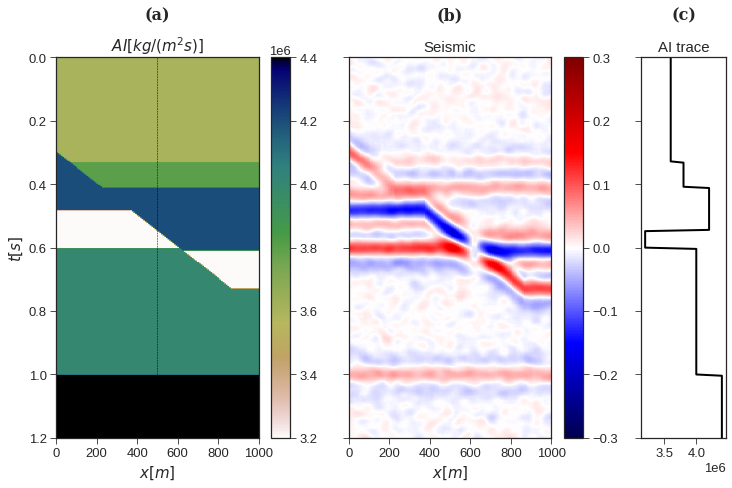

In [8]:
# smooth model
nsmooth = 20
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)

# wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav//2+1], 8)

# operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
d = Lop * m.ravel()
d = d.reshape(nt0, nx)

# random noise
#sigman = 2e-2
#n = np.random.normal(0, sigman, d.shape)

# colored noise
sigman = 6e-2
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust')
dn = d + n

fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(np.exp(m), vmin=3.2e6, vmax=4.4e6,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[0].text(0.5, 1.1, '(a)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[0].transAxes)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'$AI [kg/(m^2s)]$')
im = axs[1].imshow(dn, cmap='seismic', vmin=-0.3, vmax=0.3, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].text(0.5, 1.1, '(b)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Seismic')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(np.exp(m[:, nx//2]), t0, 'k', lw=2)
axs[2].text(0.5, 1.1, '(c)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)
axs[2].axis('tight')
axs[2].set_title('AI trace')
plt.savefig('Figs/simple_modeldata.eps', dpi=80, bbox_inches='tight');

## 2D Post-stack inversion

We consider the following problem

$$
\mathbf{x} = arg min_\mathbf{x} \frac{\sigma}{2} ||\mathbf{W}\mathbf{D}\mathbf{x} - \mathbf{y} ||_2^2 + ||\mathbf{D} \mathbf{x}||_1
$$

In [9]:
# L2 regularized inversion
Dop = Laplacian(dims=(nt0, nx), dtype=Lop.dtype)
minv = RegularizedInversion(Lop, [Dop], dn.ravel(),
                            x0=mback.ravel(), epsRs=[10], returninfo=False,
                            **dict(iter_lim=500, damp=1e-2))
dinv = Lop*minv

minv = minv.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['L2'] = RRE(m.ravel(), minv.ravel())
psnr['L2'] = PSNR(m.ravel(), minv.ravel())
print('RRE=', rre['L2'])
print('PSNR=', psnr['L2'])

RRE= 0.0014878191634391845
PSNR= 52.71052260983752


In [10]:
# SplitBregman (Blockiness-promoting inversion with anisotropic TV)
RegL1op = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
msb = SplitBregman(Lop, [RegL1op], dn.ravel(),
                   epsRL1s=[0.03], mu=0.1,
                   niter_outer=10,
                   niter_inner=4,
                   x0=mback.ravel(), show=True,
                   **dict(iter_lim=50, damp=1e-4))[0]
dinv = Lop*msb

msb = msb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['SB'] = RRE(m.ravel(), msb.ravel())
psnr['SB'] = PSNR(m.ravel(), msb.ravel())
print('RRE=', rre['SB'])
print('PSNR=', psnr['SB'])

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 75551 rows and 75551 cols
niter_outer =  10     niter_inner =   4   tol = 1.00e-10
mu = 1.00e-01         epsL1 = [0.03]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   1.50708e+01        3.667e-02        4.529e+02
     2   1.51192e+01        4.437e-02        3.695e+02
     3   1.51579e+01        4.733e-02        3.412e+02
     4   1.51820e+01        4.988e-02        3.176e+02
     5   1.51887e+01        5.232e-02        3.057e+02
     6   1.51843e+01        5.433e-02        2.957e+02
     7   1.51682e+01        5.584e-02        2.865e+02
     8   1.51446e+01        5.717e-02        2.789e+02
     9   1.51183e+01        5.843e-02        2.729e+02
    10   1.50916e+01        5.959e-02        2.696e+02

Iterations = 10        Total time (s) = 19.21
--------------------------------------------

In [11]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
sigma=0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

mladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=mback.ravel(), niter=100, show=True)[0]
dinv = Lop*mladmm

mladmm = mladmm.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['LADMM'] = RRE(m.ravel(), mladmm.ravel())
psnr['LADMM'] = PSNR(m.ravel(), mladmm.ravel())
print('RRE=', rre['LADMM'])
print('PSNR=', psnr['LADMM'])

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.237500e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.50953e+01   1.909e+01   1.611e+00   2.070e+01
     2   1.50942e+01   1.416e+01   1.654e+00   1.582e+01
     3   1.50933e+01   1.067e+01   1.733e+00   1.240e+01
     4   1.50925e+01   8.209e+00   1.836e+00   1.004e+01
     5   1.50920e+01   6.460e+00   1.953e+00   8.413e+00
     6   1.50917e+01   5.205e+00   2.060e+00   7.265e+00
     7   1.50916e+01   4.294e+00   2.151e+00   6.444e+00
     8   1.50916e+01   3.622e+00   2.228e+00   5.850e+00
     9   1.50918e+01   3.118e+00   2.293e+00   5.411e+00
    10   1.50919e+01   2.735e+00   2.344e+00   5.078e+00
    11   1.50921e+01   2.438e+00   2.381e+00   4.820e+00
    2

In [12]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, mback.ravel(), tau=tau, mu=mu, 
                 theta=1., niter=100, show=True)
dinv = Lop*mpd

mpd = mpd.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['PD'] = RRE(m.ravel(), mpd.ravel())
psnr['PD'] = PSNR(m.ravel(), mpd.ravel())
print('RRE=', rre['PD'])
print('PSNR=', psnr['PD'])

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.237500e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.50906e+01   5.598e+00   2.097e+00   0.000e+00       7.696e+00
     2   1.50867e+01   2.045e+00   2.649e+00   0.000e+00       4.694e+00
     3   1.50840e+01   1.222e+00   2.921e+00   0.000e+00       4.143e+00
     4   1.50822e+01   9.387e-01   3.052e+00   0.000e+00       3.991e+00
     5   1.50814e+01   8.042e-01   3.113e+00   0.000e+00       3.917e+00
     6   1.50811e+01   7.273e-01   3.131e+00   0.000e+00       3.859e+00
     7   1.50814e+01   6.788e-01   3.120e+00   0.000e+00       3.798e+00
     8   1.50818e+01   6.462e-01   3

In [13]:
# Bregman with Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = .2 
l1 = L21(ndim=2)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8 # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
#tau = 1.
#mu = 0.99 / (tau * L)
tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)

mpdb_hist = []
mpdb = Bregman(l2, l1, mback.ravel(), PrimalDual, A=Dop, 
               niterouter=5, alpha=sigma, 
               #tolf=(dn.size * sigman ** 2) / 2.,# Morozov discrepancy
               bregcallback=lambda x: callback(x, mpdb_hist),
               show=True, **dict(tau=tau, mu=mu, theta=1., niter=100))
dinv = Lop*mpdb

mpdb = mpdb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['Breg-PD'] = RRE(m.ravel(), mpdb.ravel())
psnr['Breg-PD'] = PSNR(m.ravel(), mpdb.ravel())
print('RRE=', rre['Breg-PD'])
print('PSNR=', psnr['Breg-PD'])

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function PrimalDual at 0x153e47fb3dc0>
alpha = 2.000000e-01	tolf = 1.000000e-10	tolx = 1.000000e-10
niter = 5

   Itn       x[0]          f           g       J = f + g
     1   1.50877e+01   8.768e+00   3.319e+01   4.196e+01
     2   1.50930e+01   1.512e+00   4.305e+01   4.456e+01
     3   1.50919e+01   1.121e+00   4.594e+01   4.706e+01
     4   1.50899e+01   9.820e-01   4.749e+01   4.847e+01
     5   1.50875e+01   9.224e-01   4.854e+01   4.946e+01

Total time (s) = 27.08
---------------------------------------------------------

RRE= 0.001190867267453162
PSNR= 53.669795500468


In [14]:
print(psnr)

{'L2': 52.71052260983752, 'SB': 54.433592131879806, 'LADMM': 54.05158742108165, 'PD': 55.02567583492297, 'Breg-PD': 53.669795500468}


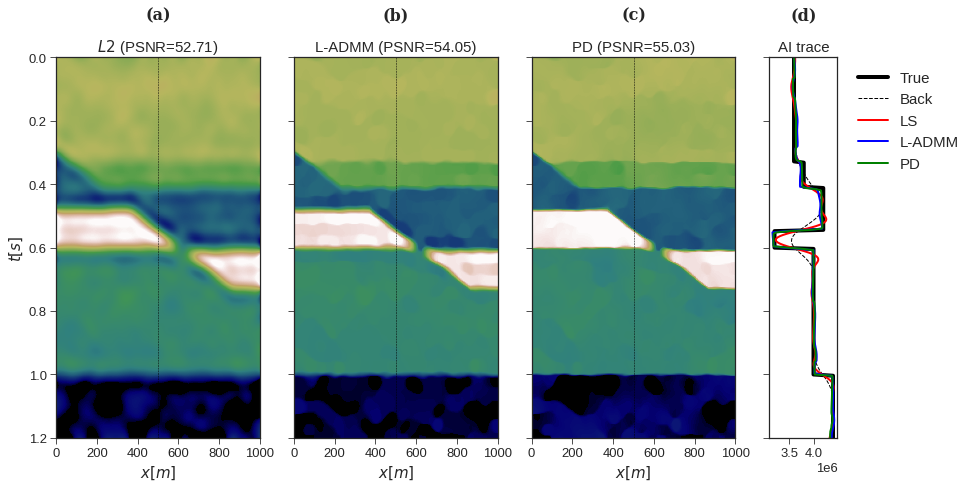

In [15]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14, 7),
                        gridspec_kw={'width_ratios': [3, 3, 3, 1]})
axs[0].imshow(np.exp(minv), vmin=3.2e6, vmax=4.4e6,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[0].text(0.5, 1.1, '(a)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[0].transAxes)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'$L2$ (PSNR=%.2f)' % psnr['L2'])
axs[1].imshow(np.exp(mladmm), vmin=3.2e6, vmax=4.4e6,
              cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[1].text(0.5, 1.1, '(b)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('L-ADMM (PSNR=%.2f)' % psnr['LADMM'])
axs[1].axis('tight')
axs[2].imshow(np.exp(mpd), vmin=3.2e6, vmax=4.4e6,
              cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[2].text(0.5, 1.1, '(c)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('PD (PSNR=%.2f)' % psnr['PD'])
axs[2].axis('tight')
#axs[3].imshow(np.exp(mpdb), vmin=3.2e6, vmax=4.4e6,
#              cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
#axs[3].axvline(x[nx//2], c='k', ls='--', lw=0.5)
#axs[3].set_xlabel(r'$x [m]$')
#axs[3].set_title('Breg-PD (PSNR=%.2f)' % psnr['Breg-PD'])
#axs[3].axis('tight')
axs[3].plot(np.exp(m[:, nx//2]), t0, 'k', lw=4, label='True')
axs[3].plot(np.exp(mback[:, nx//2]), t0, '--k', lw=1, label='Back')
axs[3].plot(np.exp(minv[:, nx//2]), t0, 'r', lw=2, label='LS')
axs[3].plot(np.exp(msb[:, nx//2]), t0, 'b', lw=2, label='L-ADMM')
axs[3].plot(np.exp(mpd[:, nx//2]), t0, 'g', lw=2, label='PD')
axs[3].text(0.5, 1.1, '(d)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[3].transAxes)
axs[3].legend(bbox_to_anchor=(1.1, 1.))
axs[3].axis('tight')
axs[3].set_title('AI trace')
plt.savefig('Figs/simple_inversions.eps', dpi=80);

## 2D Post-stack  segmentation

Let's start by taking one of our previous inversion results and use it as input to a segmentation algorithm

In [16]:
cl = np.unique(m)
print(cl)
ncl = len(cl)
cldict = {cl[i]:i for i in range(ncl)}

u,inv = np.unique(m, return_inverse = True)
mcl = np.array([cldict[x] for x in u])[inv].reshape(m.shape)

[14.97866137 15.0964444  15.15051162 15.20180492 15.25059508 15.2971151 ]


Create true horizons

In [17]:
facies_colors = ['red', 'green', 'blue', 'yellow', '#11570C', '#A2750C']
cmap_facies = \
    LinearSegmentedColormap.from_list('name', facies_colors, 6)

In [18]:
hors = {}
for icl in range(ncl-1):
    mclass = (mcl == icl).astype(np.int)
    
    cabove = np.zeros(nx)
    cbelow = np.zeros(nx)
    hor = -1 * np.ones(nx)
    for ix in range(nx):
        it = np.where(np.diff(mclass[:, ix]) == -1)[0]
        if len(it) > 0:
            hor[ix] = it[0]
            cabove[ix] = mcl[it[0] - 1, ix]
            cbelow[ix] = mcl[it[0] + 1, ix]
    cabove = sp.stats.mode(cabove)[0]
    cbelow = sp.stats.mode(cbelow)[0]
    
    mask = hor>=0
    hor = np.interp(np.arange(nx), np.arange(nx)[mask], hor[mask])
    hor[~mask] = np.nan
    hors['a%db%d' % (cabove, cbelow)] = hor

Segmentation

In [19]:
segpd, segpd_classes = Segment(mpd, cl, 20., 0.2, niter=60, 
                               show=True,  kwargs_simplex=dict(engine='numba', maxiter=10, call=False))

segpd_l2, segpd_classes_l2 = Segment(minv, cl, 20., 0.2, niter=60,
                                     show=True,  kwargs_simplex=dict(engine='numba', maxiter=10, call=False))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 60

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.82184e-01   0.000e+00   1.533e+02   4.064e+03       4.217e+03
     2   1.42666e-01   0.000e+00   2.178e+02   2.571e+03       2.789e+03
     3   9.06005e-02   0.000e+00   2.531e+02   1.903e+03       2.156e+03
     4   3.22515e-02   0.000e+00   2.746e+02   1.501e+03       1.776e+03
     5   0.00000e+00   0.000e+00   2.872e+02   1.205e+03       1.492e+03
     6   0.00000e+00   0.000e+00   2.948e+02   1.031e+03       1.325e+03
     7   0.00000e+00   0.000e+00   3.009e+02   9.304e+02       1.231e+03
     8

[3200000. 3600000. 3800000. 4000000. 4200000. 4400000.]


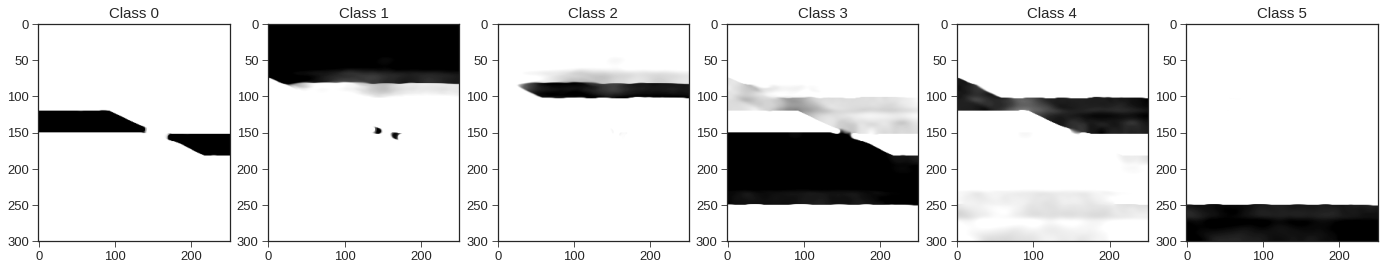

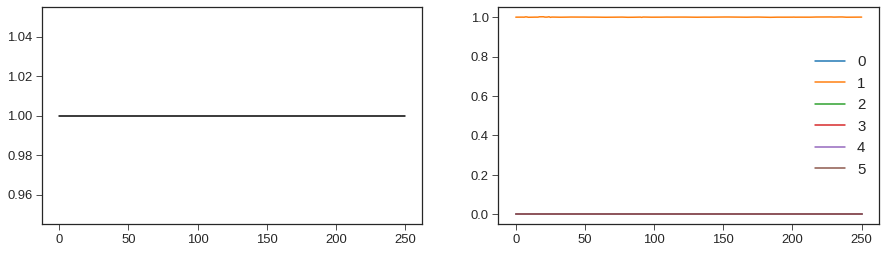

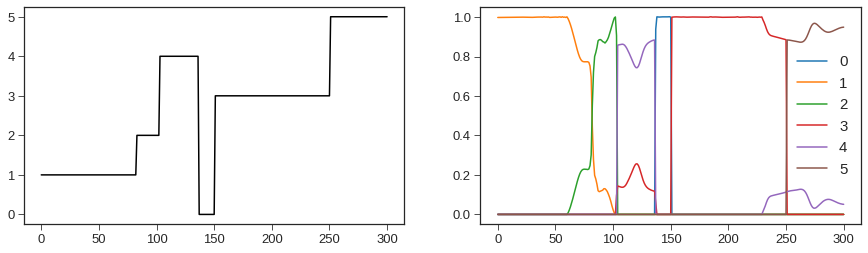

In [20]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[20], 'k')
for icl in range(ncl):
    axs[1].plot(segpd.reshape(nt0, nx, ncl)[20, :, icl], label=icl)
axs[1].legend(loc='right')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[:, nx//2], 'k')
for icl in range(ncl):
    axs[1].plot(segpd.reshape(nt0, nx, ncl)[:, nx//2, icl], label=icl)
axs[1].legend(loc='right');

print(np.exp(cl))

[3200000. 3600000. 3800000. 4000000. 4200000. 4400000.]


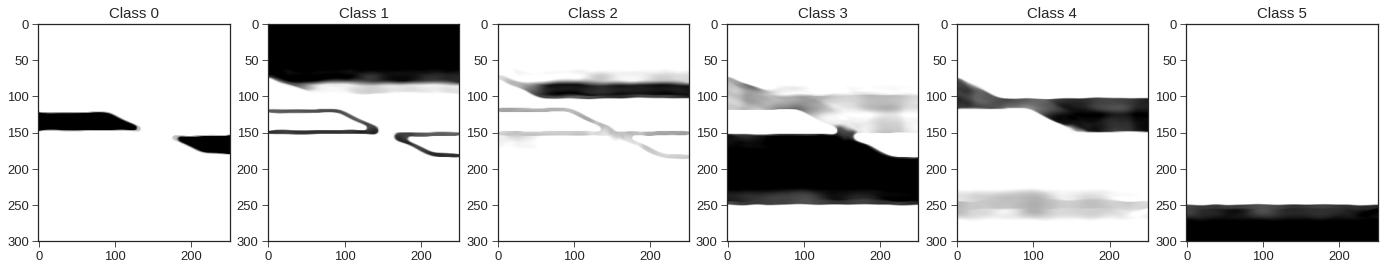

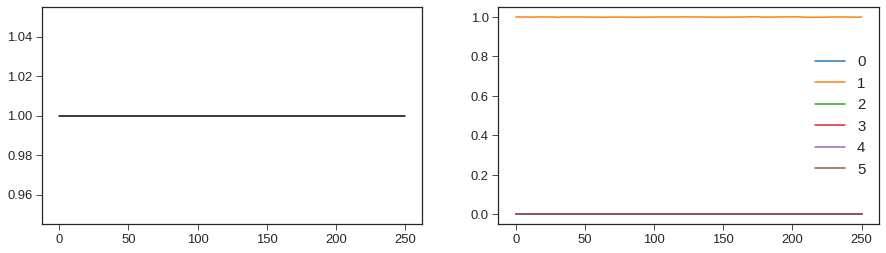

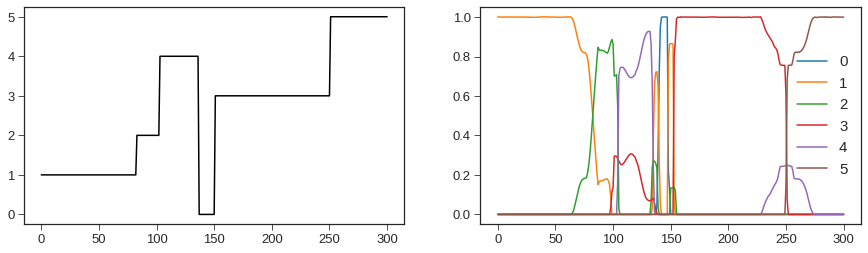

In [21]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd_l2[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[20], 'k')
for icl in range(ncl):
    axs[1].plot(segpd_l2.reshape(nt0, nx, ncl)[20, :, icl], label=icl)
axs[1].legend(loc='right')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[:, nx//2], 'k')
for icl in range(ncl):
    axs[1].plot(segpd_l2.reshape(nt0, nx, ncl)[:, nx//2, icl], label=icl)
axs[1].legend(loc='right');

print(np.exp(cl))

### Extract horizons

Class: 0
Start: 2021-02-28 14:58:19.496416
Compute TV Completed: 0:00:00.004104 sec
Get horizon points Completed: 0:00:00.000443 sec
Get separated horizons Completed: 0:00:02.552149 sec
Interpolate horizons Completed: 0:00:00.001893 sec
Label horizons Completed: 0:00:00.007216 sec
Join horizons Completed: 0:00:00.013996 sec
Regredding horizons Completed: 0:00:00.002952 sec
End: 2021-02-28 14:58:22.079838
Duration: 0:00:02.583422
 
Class: 1
Start: 2021-02-28 14:58:22.080089
Compute TV Completed: 0:00:00.003883 sec
Get horizon points Completed: 0:00:00.000301 sec
Get separated horizons Completed: 0:00:01.402483 sec
Interpolate horizons Completed: 0:00:00.000467 sec
Label horizons Completed: 0:00:00.002100 sec
Join horizons Completed: 0:00:00.003872 sec
Regredding horizons Completed: 0:00:00.001397 sec
End: 2021-02-28 14:58:23.495208
Duration: 0:00:01.415119
 
Class: 2
Start: 2021-02-28 14:58:23.495258
Compute TV Completed: 0:00:00.003667 sec
Get horizon points Completed: 0:00:00.000309 s

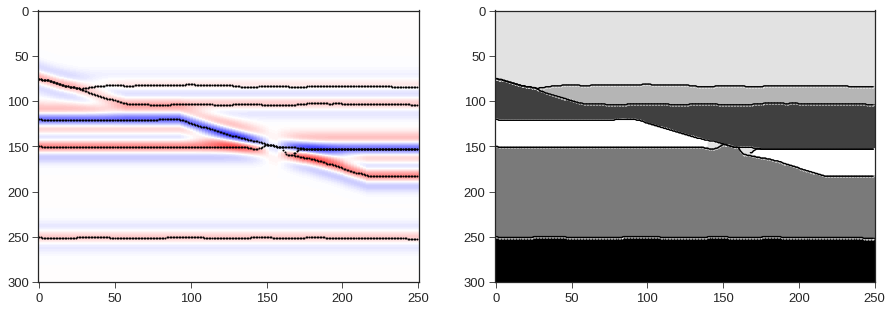

In [22]:
horizon_list = multiclass_horizons(ncl, segpd_classes, 
                                   nn_lim=2, line_minlen=5, 
                                   verbose=True)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(d, vmin=-0.5, vmax=0.5, aspect="auto", cmap='seismic')
for i,h in horizon_list.iterrows():  
    if h['chosen']:
        ax1.scatter(h['x'], h['y'], c='k', s=1)

ax2.imshow(segpd_classes, aspect="auto")
for i,h in horizon_list.iterrows():  
    if h['chosen']:
        ax2.scatter(h['x'], h['y'], c='w', s=1)
        ax2.plot(h['regx'], h['regy'], c='k')

Compute MSE between true and estimated horizons

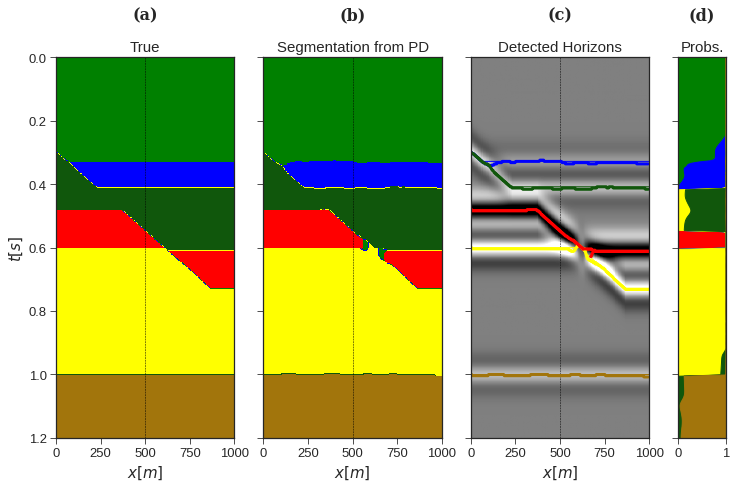

In [23]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 7),
                        gridspec_kw={'width_ratios': [3, 3, 3, 0.8]})
axs[0].imshow(mcl, cmap=cmap_facies, vmin=-0.5, vmax=5.5, 
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[0].text(0.5, 1.1, '(a)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[0].transAxes)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title('True')
axs[1].imshow(segpd_classes, cmap=cmap_facies, vmin=-0.5, vmax=5.5, 
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[1].text(0.5, 1.1, '(b)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[1].axis('tight')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Segmentation from PD')
axs[2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[2].axis('tight')
chors = ['yellow', 'blue', '#11570C', '#A2750C',  'red', '#A2750C']
for ihor, horkey in enumerate(hors.keys()):
    axs[2].plot(np.arange(nx) * dx, hors[horkey]* dt0, chors[ihor], lw=1)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
        for hsel in horsel:
            axs[2].plot(hsel['regx']* dx, hsel['regy']* dt0, chors[ihor], lw=3)
axs[2].text(0.5, 1.1, '(c)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('Detected Horizons')
probs = segpd.reshape(nt0, nx, ncl)[:, nx//2]
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((nt0, 1)), cdf))
for icl in range(ncl):
    axs[3].fill_betweenx(t0, cdf[:, icl], cdf[:, icl+1], color=facies_colors[icl])
axs[3].text(0.5, 1.1, '(d)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[3].transAxes)
axs[3].set_xlim(0, 1)
axs[3].set_title('Probs.')
plt.savefig('Figs/simple_segmentation.eps', dpi=80);

Same but with L2 inversion

Class: 0
Start: 2021-02-28 14:58:33.876304
Compute TV Completed: 0:00:00.003536 sec
Get horizon points Completed: 0:00:00.000453 sec
Get separated horizons Completed: 0:00:02.196556 sec
Interpolate horizons Completed: 0:00:00.001589 sec
Label horizons Completed: 0:00:00.006985 sec
Join horizons Completed: 0:00:00.012146 sec
Regredding horizons Completed: 0:00:00.003636 sec
End: 2021-02-28 14:58:36.102025
Duration: 0:00:02.225721
 
Class: 1
Start: 2021-02-28 14:58:36.102412
Compute TV Completed: 0:00:00.003597 sec
Get horizon points Completed: 0:00:00.000301 sec
Get separated horizons Completed: 0:00:06.365697 sec
Interpolate horizons Completed: 0:00:00.003835 sec
Label horizons Completed: 0:00:00.015494 sec
Join horizons Completed: 0:00:00.026892 sec
Regredding horizons Completed: 0:00:00.007145 sec
End: 2021-02-28 14:58:42.525949
Duration: 0:00:06.423537
 
Class: 2
Start: 2021-02-28 14:58:42.526324
Compute TV Completed: 0:00:00.003542 sec
Get horizon points Completed: 0:00:00.000259 s

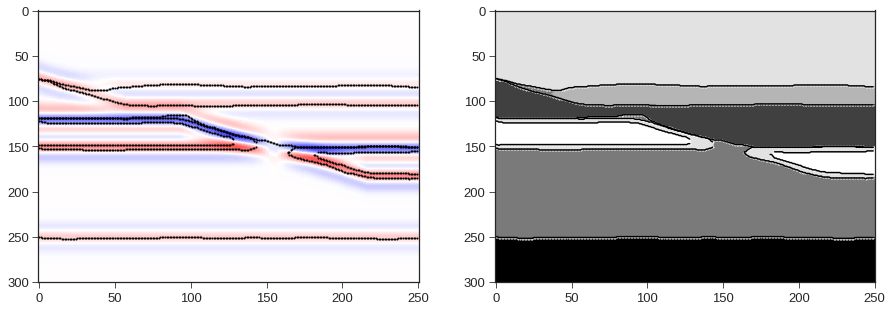

In [24]:
horizon_list_l2 = multiclass_horizons(ncl, segpd_classes_l2, 
                                      nn_lim=2, line_minlen=5, 
                                      verbose=True)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(d, vmin=-0.5, vmax=0.5, aspect="auto", cmap='seismic')
for i,h in horizon_list_l2.iterrows():  
    if h['chosen']:
        ax1.scatter(h['x'], h['y'], c='k', s=1)

ax2.imshow(segpd_classes_l2, aspect="auto")
for i,h in horizon_list_l2.iterrows():  
    if h['chosen']:
        ax2.scatter(h['x'], h['y'], c='w', s=1)
        ax2.plot(h['regx'], h['regy'], c='k')

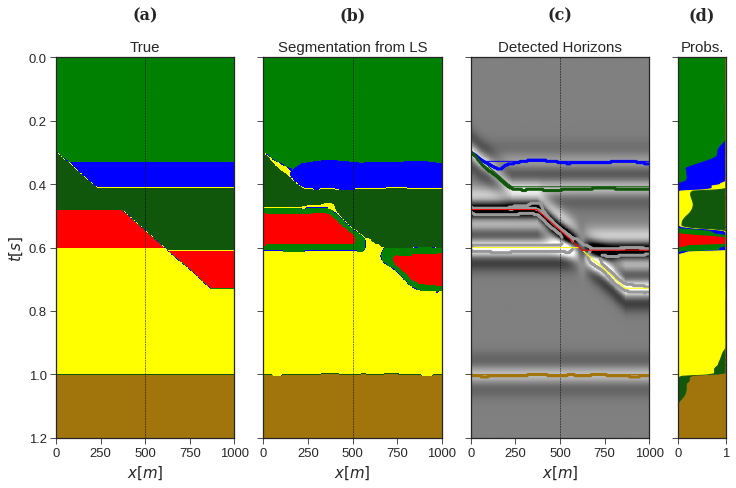

In [25]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 7),
                        gridspec_kw={'width_ratios': [3, 3, 3, 0.8]})
axs[0].imshow(mcl, cmap=cmap_facies, vmin=-0.5, vmax=5.5, 
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[0].text(0.5, 1.1, '(a)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[0].transAxes)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title('True')
axs[1].imshow(segpd_classes_l2, cmap=cmap_facies, vmin=-0.5, vmax=5.5, 
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].text(0.5, 1.1, '(b)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[1].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Segmentation from LS')
axs[2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//2], c='k', ls='--', lw=0.5)
axs[2].text(0.5, 1.1, '(c)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)
axs[2].axis('tight')

hornotsel = [h for i, h in horizon_list_l2.iterrows() if h['chosen'] and h['h_id'] not in list(hors.keys())]
for hsel in hornotsel:
    axs[2].plot(hsel['regx']* dx, hsel['regy']* dt0, '#999999', lw=3)
chors = ['yellow', 'blue', '#11570C', '#A2750C',  'red', '#A2750C']
for ihor, horkey in enumerate(hors.keys()):
    axs[2].plot(np.arange(nx) * dx, hors[horkey]* dt0, chors[ihor], lw=1)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list_l2.iterrows() if h['chosen'] and h['h_id'] == horkey]
        for hsel in horsel:
            axs[2].plot(hsel['regx']* dx, hsel['regy']* dt0, chors[ihor], lw=3)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('Detected Horizons')
probs = segpd_l2.reshape(nt0, nx, ncl)[:, nx//2]
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((nt0, 1)), cdf))
for icl in range(ncl):
    axs[3].fill_betweenx(t0, cdf[:, icl], cdf[:, icl+1], color=facies_colors[icl])
axs[3].text(0.5, 1.1, '(d)', ha='center', fontsize=16, fontweight='bold', 
            family='serif', transform=axs[3].transAxes)
axs[3].set_xlim(0, 1)
axs[3].set_title('Probs.')
plt.savefig('Figs/simple_segmentation_l2.eps', dpi=80);